Pneumonia - Post-hoc interpretability of a CNN model
===
Inspiration from:

*  Kaggle Pneumonia colab: https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy

# Preliminaries

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import math
# import random

In [2]:
# from scipy.stats import norm
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import torch
# import torch.nn.functional as F
# import param

In [3]:
# import sklearn as sk
# import scipy
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_curve, auc
# , precision_score, recall_score, auc, roc_curve, roc_auc_score, accuracy_score, classification_report 

In [4]:
# import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
# # from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from sklearn.metrics import classification_report,confusion_matrix
# from keras.callbacks import ReduceLROnPlateau

In [5]:
# import param
# import panel as pn
# pn.extension()
# import datetime as dt
import importlib
from importlib import reload
# from tqdm import tqdm

In [6]:
# Images-related imports
import cv2

In [7]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

2024-04-15 19:23:39.266923: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 19:23:40.662097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 19:23:45.833837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

In [9]:
# class NotebookParams(param.Parameterized):
#     lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
#     lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
#     lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
#     lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
#     epochs                   = param.Integer(default=5 ,bounds=(1,2000))
#     data_set                 = param.ObjectSelector(default="validation",objects=['train', 'validation', 'train + validation', 'test'])
#     stand_features           = param.Boolean(True, doc="Whether we want to standardize numerical features")
#     use_lasso                = param.Boolean(True)
#     use_focal_loss           = param.Boolean(True)
#     iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
#     iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
#     add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
#     test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
#     random_state_test_train_split = param.Integer(42)
# # pn.Param(CustomExample.param, widgets={
# #     'select_string': {'type': pn.widgets.RadioButtonGroup, 'button_type': 'primary'},
# #     'select_number': pn.widgets.DiscretePlayer}
# # )
# base = NotebookParams()

## Import Data

In [10]:
# Input data files are available in the "../../../untracked_data..." directory.
# Running this will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../../../untracked_data/chest_data/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../../untracked_data/chest_data/chest_xray/.DS_Store
../../../untracked_data/chest_data/chest_xray/test/.DS_Store
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0256-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0374-0001-0002.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0286-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0370-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0333-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/IM-0007-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/IM-0089-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0300-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0328-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NORMAL/NORMAL2-IM-0237-0001.jpeg
../../../untracked_data/chest_data/chest_xray/test/NOR

In [11]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
test = lib.get_training_data(
    '../../../untracked_data/chest_data/chest_xray/test',
		img_size=img_size,
		labels=labels,
        )

## Data Preprocessing

In [12]:
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

# Normalize the data
x_test = np.array(x_test) / 255

# resize data for deep learning
x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Load model

In [13]:
# load model
from keras import models
model = models.load_model('cnn_v0.h5')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,403 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

 Optimizer params: 2 (12.00 B)

## Predictions

In [14]:
x_test.shape

(624, 150, 150, 1)

In [15]:
print("Generate a prediction, probability that an image is of type 1 (Normal)")
predictions_proba = model.predict(x_test)

Generate a prediction, probability that an image is of type 1 (Normal)


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step


In [16]:
predictions = np.copy(predictions_proba)
predictions[predictions <= 0.5] = 0.
predictions[predictions > 0.5] = 1.

In [17]:
predictions_proba.shape

(624, 1)

<Axes: >

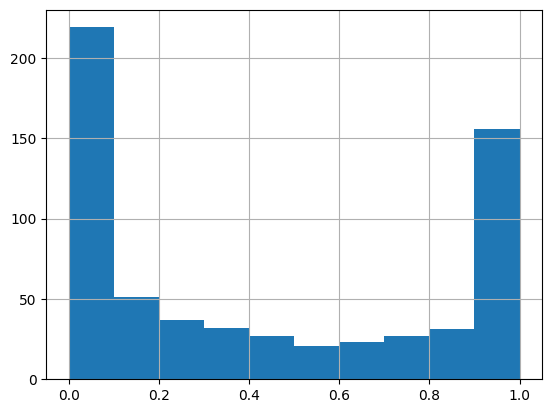

In [18]:
pd.Series(data=predictions_proba.flatten(), name='probability of xray being normal').hist()

<Axes: >

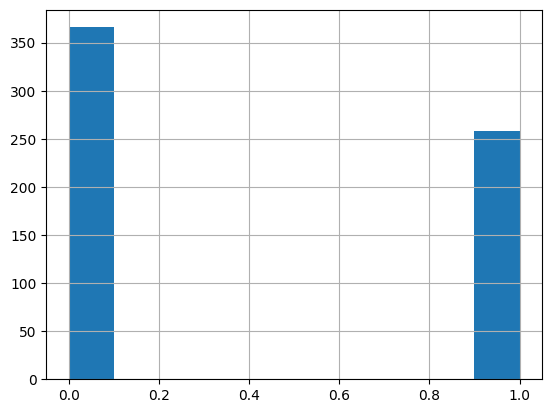

In [19]:
pd.Series(data=predictions.flatten(), name='predicted_classes').hist()

### Establishing typology of images:

*  Correct predictions or not
*  Normal or Pneumonia outcome

In [44]:
correct = np.nonzero(predictions.flatten() == y_test)[0]
incorrect = np.nonzero(predictions.flatten() != y_test)[0]

In [49]:
# Creating a dictionary of indexes of examples according to their typology
# TODO[jpinole]: Redo it with pandas, will be more elegant/ efficient
examples_typology = {}
examples_typology['correct'] = {
	'Normal': [],
	'Pneumonia': []
}
examples_typology['incorrect'] = {
	'Normal': [],
	'Pneumonia': []
}

for idx in correct:
	example_img = test[idx]
	if example_img[1] == 0:
		examples_typology['correct']['Normal'].append(idx)
	else:
		examples_typology['correct']['Pneumonia'].append(idx)
    
for idx in incorrect:
	example_img = test[idx]
	if example_img[1] == 0:
		examples_typology['incorrect']['Normal'].append(idx)
	else:
		examples_typology['incorrect']['Pneumonia'].append(idx)

In [60]:
sorted_examples_typology = {}
sorted_examples_typology['correct'] = {
	'Normal': [],
	'Pneumonia': []
}
sorted_examples_typology['incorrect'] = {
	'Normal': [],
	'Pneumonia': []
}

for sorted_idx in index_sorted_by_prediction_proba:
	if sorted_idx in examples_typology['correct']['Normal']:
		sorted_examples_typology['correct']['Normal'].append(sorted_idx)
	elif sorted_idx in examples_typology['correct']['Pneumonia']:
		sorted_examples_typology['correct']['Pneumonia'].append(sorted_idx)
	elif sorted_idx in examples_typology['incorrect']['Normal']:
		sorted_examples_typology['incorrect']['Normal'].append(sorted_idx)
	else:
		sorted_examples_typology['incorrect']['Pneumonia'].append(sorted_idx)

In [53]:
# len(examples_typology['correct']['Pneumonia'])

207

In [54]:
# len(examples_typology['correct']['Normal'])

339

# Integrated Gradients

[New] Inspired from:

*  https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

[Old] Inspired from:

*  Main repository: https://github.com/ankurtaly/Integrated-Gradients/tree/master
*  ig_inception notebook: https://github.com/ankurtaly/Integrated-Gradients/blob/master/ig_inception.ipynb


In [21]:
import tensorflow as tf
# import tensorflow_hub as hub

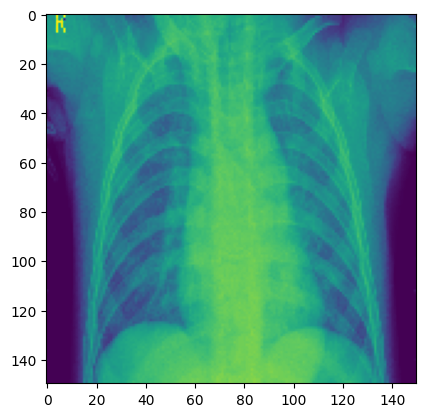

In [22]:
plt.imshow(test[0][0])
plt.show()

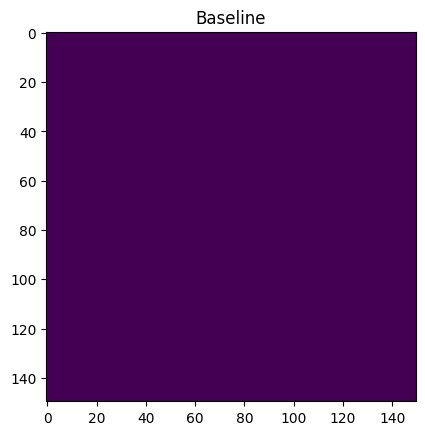

In [23]:
# baseline = tf.zeros(shape=(150,150), dtype=tf.uint8)
baseline = tf.zeros(shape=(150,150))
plt.imshow(baseline)
plt.title("Baseline")
# plt.axis('off')
plt.show()

See below how the interpolation between a baseline and an image look like.

In [24]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

interpolated_images = lib.interpolate_images(
    baseline=baseline,
    image=test[0][0]/255,
		# image=x_test[0],
    alphas=alphas)

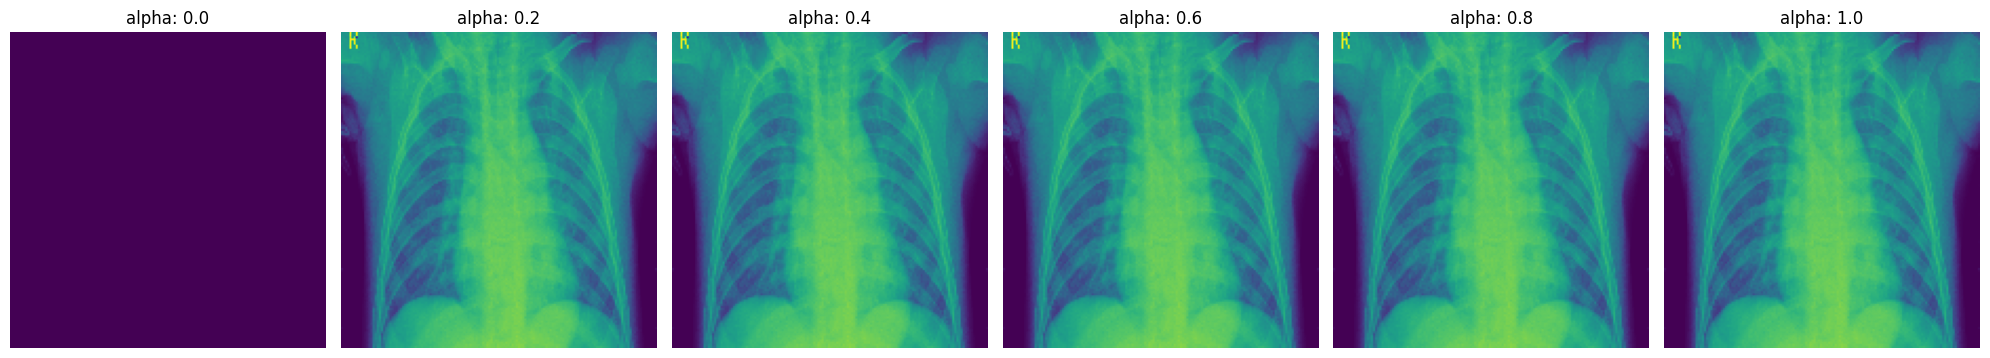

In [25]:
fig = plt.figure(figsize=(20, 20))
i = 0

for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
	i += 1
	plt.subplot(1, len(alphas[0::10]), i)
	plt.title(f'alpha: {alpha:.1f}')
	plt.imshow(tf.reshape(image, [150,150]))
	plt.axis('off')

	plt.tight_layout()

In [27]:
x_test[0].shape

(150, 150, 1)

In [28]:
a = x_test[0].squeeze()
b = np.array(test[0][0]) / 255
check = a == b
print(check)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [41]:
import py_lib as lib
reload(lib)
import py_lib as lib

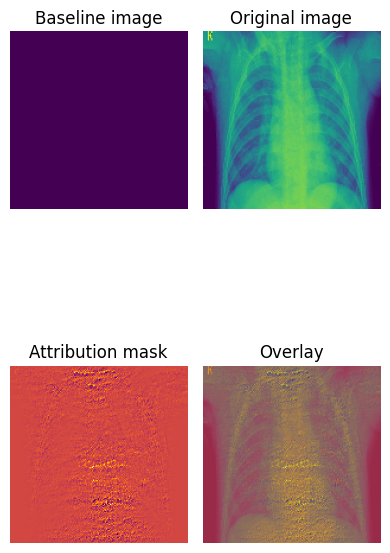

In [43]:
fig, attributions = lib.plot_img_attributions(
    model=model,
		image=test[0][0],
		baseline=baseline,
		m_steps=5,
		cmap=plt.cm.inferno,
		overlay_alpha=0.4,
		target_is_class_zero=True,
		figsize=(4,8)
		)

### 5 Healthy Cases

In [74]:
top_correct_healthy = sorted_examples_typology['correct']['Normal'][-6:-1]
top_correct_healthy

[181, 107, 73, 276, 11]

In [77]:
top_incorrect_healthy = sorted_examples_typology['incorrect']['Normal'][-6:-1]
top_incorrect_healthy

[124, 119, 198, 180, 336]

In [72]:
sorted_examples_typology['correct']['Normal']

[290,
 232,
 208,
 112,
 236,
 7,
 99,
 35,
 177,
 321,
 265,
 9,
 77,
 237,
 58,
 251,
 260,
 315,
 127,
 272,
 286,
 300,
 143,
 363,
 160,
 135,
 1,
 253,
 41,
 317,
 153,
 345,
 289,
 38,
 310,
 297,
 164,
 84,
 85,
 154,
 225,
 19,
 199,
 376,
 172,
 373,
 305,
 192,
 185,
 101,
 262,
 214,
 379,
 263,
 40,
 372,
 72,
 296,
 375,
 75,
 17,
 324,
 36,
 215,
 104,
 203,
 120,
 318,
 93,
 111,
 141,
 159,
 299,
 118,
 252,
 8,
 207,
 78,
 352,
 309,
 326,
 57,
 51,
 83,
 44,
 282,
 103,
 170,
 163,
 138,
 341,
 291,
 227,
 327,
 14,
 344,
 167,
 63,
 68,
 342,
 61,
 361,
 62,
 140,
 130,
 5,
 30,
 56,
 102,
 162,
 255,
 182,
 350,
 66,
 381,
 67,
 105,
 387,
 213,
 249,
 54,
 6,
 302,
 312,
 74,
 52,
 250,
 147,
 307,
 139,
 366,
 27,
 383,
 47,
 82,
 319,
 223,
 76,
 94,
 364,
 191,
 271,
 348,
 295,
 64,
 294,
 179,
 171,
 148,
 354,
 386,
 81,
 178,
 16,
 195,
 306,
 245,
 234,
 110,
 378,
 174,
 264,
 346,
 369,
 49,
 69,
 338,
 53,
 266,
 176,
 114,
 268,
 92,
 155,
 43,
 0,
 2,

In [62]:
predictions_proba.flatten()[top_correct_healthy]

array([1.3370419e-13, 3.5807390e-09, 3.9277546e-09, 4.7411124e-09,
       9.0458316e-09], dtype=float32)

In [79]:
test[:,1]

TypeError: list indices must be integers or slices, not tuple

In [81]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [88]:
predictions_proba_df = pd.DataFrame(predictions_proba.flatten(), columns=['prediction_probability'])
predictions_proba_df['true_value'] = y_test
predictions_proba_df['outcome'] = predictions_proba_df['true_value']
predictions_proba_df['outcome'] = predictions_proba_df['outcome'].replace(
	{0: 'Pneumonia', 1: 'Normal'}
)
predictions_proba_df['predictions'] = predictions.astype(int)
predictions_proba_df['is_correct'] = predictions_proba_df['predictions'] == predictions_proba_df['true_value']
predictions_proba_df = predictions_proba_df.sort_values(by=['prediction_probability'], ascending=False)
predictions_proba_df = predictions_proba_df.reset_index(drop=False)
predictions_proba_df = predictions_proba_df.rename(columns = {'index': 'initial_index'})
predictions_proba_df.head(6)

,initial_index,prediction_probability,true_value,outcome,predictions,is_correct
0,609,0.999970,1,Normal,1,True
1,464,0.999842,1,Normal,1,True
2,621,0.999830,1,Normal,1,True
3,504,0.999794,1,Normal,1,True
4,616,0.999569,1,Normal,1,True
5,471,0.999490,1,Normal,1,True


In [75]:
predictions_proba_df.head(10)

,index,prediction_probability
0,609,0.999970
1,464,0.999842
2,621,0.999830
3,504,0.999794
4,616,0.999569
5,471,0.999490
6,475,0.999464
7,514,0.999446
8,522,0.999386
9,448,0.999310


In [70]:
predictions_proba_df.describe()

,index,prediction_probability
count,624.000000,6.240000e+02
mean,311.500000,4.310499e-01
std,180.277564,3.967556e-01
min,0.000000,1.337042e-13
25%,155.750000,2.990832e-02
50%,311.500000,3.081848e-01
75%,467.250000,8.990452e-01
max,623.000000,9.999701e-01


### 5 Unhealthy cases

# GRAD-Cam

Inspired from:

*  https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

In [99]:
# load model
from keras import models
model = models.load_model('cnn_v0.h5')

In [93]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName
		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.output_shape) == 4:
				return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]
		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
		return heatmap


	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

In [94]:
# import the necessary packages
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import imutils
import cv2


In [95]:
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
image = test[-10][0]
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
# image = tf.squeeze(image, [3])
# image = imagenet_utils.preprocess_input(image)

In [96]:
# use the network to make predictions on the input image and find
# the class label index with the largest corresponding probability
# preds = model(test[-1][0])
preds = model(image)
# i = np.argmax(preds[0])
# # decode the ImageNet predictions to obtain the human-readable label
# decoded = imagenet_utils.decode_predictions(preds)
# (imagenetID, label, prob) = decoded[0][0]
# label = "{}: {:.2f}%".format(label, prob * 100)
# print("[INFO] {}".format(label))

In [98]:
preds

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [101]:
lala = model(tf.reshape(test[-10][0], [1, 150, 150, 1]))
lala

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [102]:
lala = model(x_test[0:10,:,:,:])

In [103]:
lala

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[4.3380838e-02],
       [1.8149816e-05],
       [4.3501835e-02],
       [8.1064694e-02],
       [1.0837660e-01],
       [5.8836672e-03],
       [1.0402227e-02],
       [1.1596616e-08],
       [1.6184042e-03],
       [1.0244152e-06]], dtype=float32)>

# Graveyard

(0.0, 1.0)

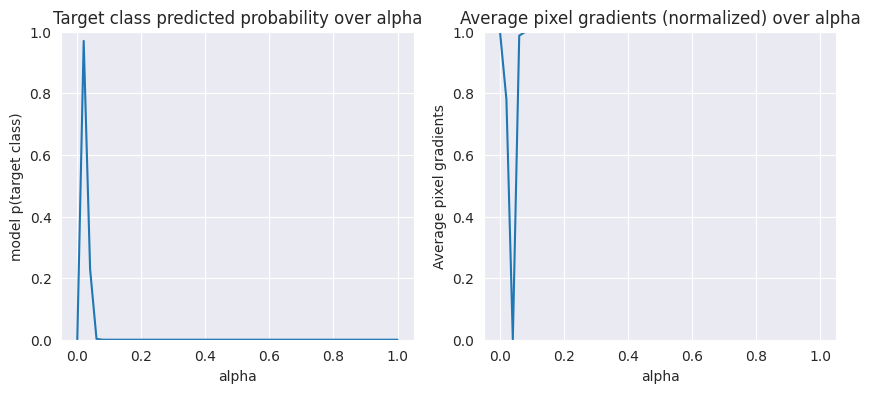

In [ ]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.set_xlabel('alpha')
ax1.plot(alphas, pred)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g., (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1])

In [ ]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [ ]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

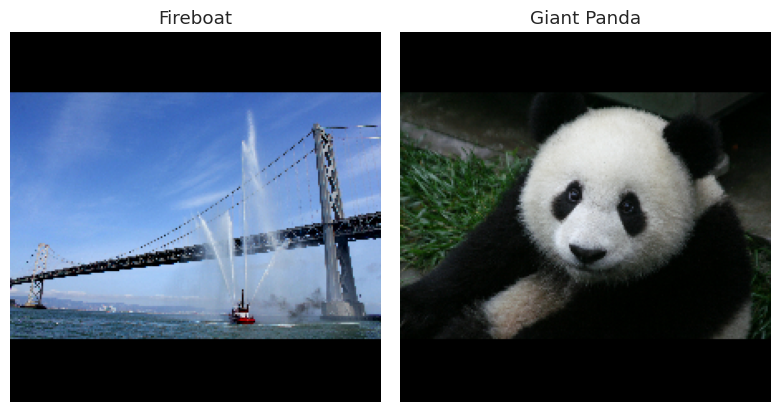

In [ ]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

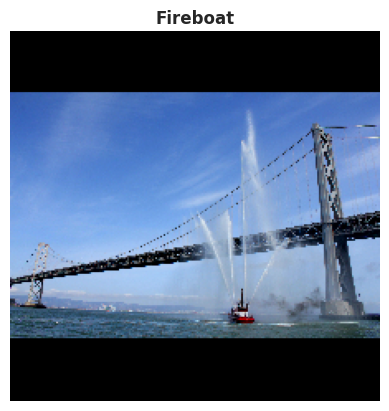

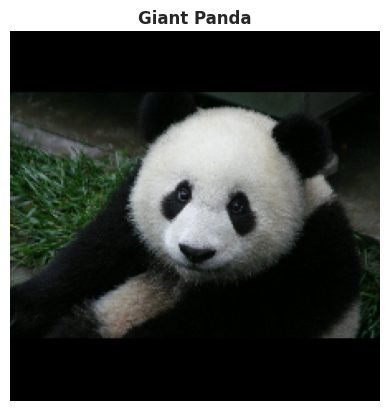

In [ ]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)
  
  def compute_l1_loss(self, w):
      return torch.abs(w).sum()

# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-pytorch.md

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        print('be loss is {}'.format(be_loss))
        print('pt is {}'.format(pt))
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss